In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## imports

In [ ]:
import pandas as pd  # Used for data manipulation and analysis, particularly for working with DataFrames.
import numpy as np  # Provides numerical computing capabilities, including arrays and mathematical operations.
import matplotlib.pyplot as plt  # Used for data visualization, including creating plots and graphs.
import seaborn as sns  # Built on top of Matplotlib, used for statistical data visualization and enhancing plots.
import torch  # Provides deep learning functionalities and tensor operations, commonly used with PyTorch models.
from transformers import BartForSequenceClassification, BartTokenizer  # Used for NLP tasks, particularly BART model for sequence classification.
from sklearn.model_selection import train_test_split  # Splits dataset into training and testing sets for machine learning models.
from sklearn.ensemble import RandomForestRegressor  # Implements a Random Forest regression model for predictive analytics.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Provides performance metrics for regression models.
import joblib  # Used for saving and loading trained machine learning models and preprocessing objects.

# Ensure that the file 'dummy_training_data.xlsx' is in your working directory.

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/dummy_training_data.xlsx")
df["customer_review"].fillna("No review provided", inplace=True) # replacing missing values

<ipython-input-3-80384c3c87bf>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["customer_review"].fillna("No review provided", inplace=True) # replacing missing values


# Sentiment Analysis Setup

In [ ]:
model_name = "facebook/bart-large-mnli" # transformer : pre trained sequence classification model from FB AI for text classification
tokenizer = BartTokenizer.from_pretrained(model_name) # converts text into tokenized format for model inference
bart_model = BartForSequenceClassification.from_pretrained(model_name, num_labels=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [ ]:
def analyze_sentiment(text):
    """
    Compute the sentiment score as the difference between positive and negative
    probabilities from BART, and apply penalties for negative reviews and bonuses
    for positive reviews based on keywords.
    """
    # Tokenizing and processing reviews to predict score
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        logits = bart_model(**inputs).logits

    # Converting model logits into class probabilities
    scores = torch.nn.functional.softmax(logits, dim=-1).tolist()[0]

    # Assumed label order: [Negative, Neutral, Positive]
    base_score = scores[2] - scores[0]

    # Apply penalty for negative keywords
    negative_keywords = ["poor", "bad", "subpar", "rude", "dirty", "late"]
    if any(word in text.lower() for word in negative_keywords):
        base_score -= 0.7  # Adjust this penalty as needed

    # Apply bonus for positive keywords
    positive_keywords = ["excellent", "good", "great", "friendly", "amazing", "smooth"]
    if any(word in text.lower() for word in positive_keywords):
        base_score += 0.7  # Adjust this bonus as needed

    return base_score


# Compute sentiment scores and convert them to a 1–5 scale rating.

In [ ]:
# Feature engineering
# Compute sentiment scores and convert them to a 1–5 scale rating.
df["review_sentiment"] = df["customer_review"].apply(analyze_sentiment)
df["sentiment_rating"] = (df["review_sentiment"] + 1) * 2.5   # maps score from (-1,1) → (1,5)

# Overall Rating Calculation

## Overall rating is a weighted combination: 70% average_rating, 30% sentiment_rating

In [ ]:
df["overall_rating"] = (0.7 * df["average_rating"]) + (0.3 * df["sentiment_rating"])

# Aggregate reviews by driver

In [ ]:
# If a driver has multiple reviews, aggregate them by averaging the ratings.
agg_df = df.groupby("driver_id").agg({
    "average_rating": "mean",
    "sentiment_rating": "mean"
}).reset_index()
agg_df["overall_rating"] = (0.7 * agg_df["average_rating"]) + (0.3 * agg_df["sentiment_rating"])

# Model Training

# Prepare features and target variable

In [ ]:
X = agg_df[["average_rating", "sentiment_rating"]]
y = agg_df["overall_rating"]

# Split the data into training (80%) and testing (20%) sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state=42) #trains multiple decision trees and aggregates their outputs.
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# Make predictions on the test set

In [ ]:
y_pred = regressor.predict(X_test)

# Evaluation Metrics on Training Test Set

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

Mean Squared Error (MSE): Measures average squared prediction error.
Root Mean Squared Error (RMSE): Standard deviation of residuals.
Mean Absolute Error (MAE): Measures average absolute error in predictions.
R² Score: Determines how well the model fits the data.

In [ ]:
print("Evaluation Metrics on Training Test Set:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R2 Score:", r2)


Evaluation Metrics on Training Test Set:
Mean Squared Error (MSE): 0.003027035319857802
Root Mean Squared Error (RMSE): 0.055018499796503015
Mean Absolute Error (MAE): 0.03665075811722758
R2 Score: 0.996420940851355


# Visualizations for Training Test Set

# Scatter Plot: Actual vs Predicted Overall Ratings

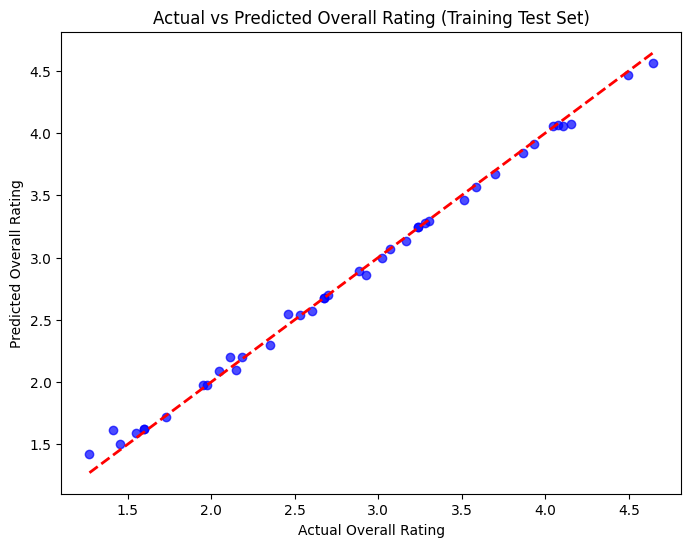

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Overall Rating")
plt.ylabel("Predicted Overall Rating")
plt.title("Actual vs Predicted Overall Rating (Training Test Set)")
plt.show()

# Residuals Distribution Plot

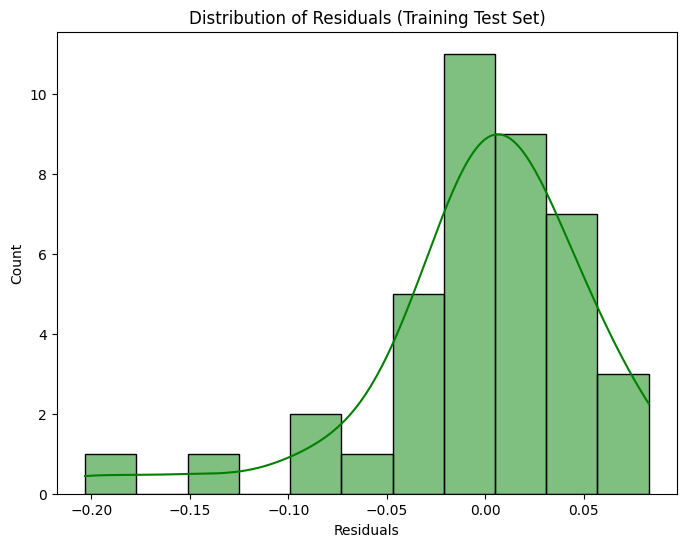

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='green')
plt.xlabel("Residuals")
plt.title("Distribution of Residuals (Training Test Set)")
plt.show()

# Save the Trained Model

In [ ]:
MODEL_FILENAME = "driver_suggestion_model.pkl"
joblib.dump(regressor, MODEL_FILENAME) #Serializes the trained model for deployment.
print("Model saved as", MODEL_FILENAME)

Model saved as driver_suggestion_model.pkl


# Reload the Model and Test with New Dummy Data

# Reload the saved model

In [ ]:
loaded_model = joblib.load(MODEL_FILENAME)
print("Model reloaded successfully.")

Model reloaded successfully.


# Create new dummy test data (different from training data)

In [ ]:
dummy_data = {
    "driver_id": [201, 202, 203, 203, 204, 205],
    "average_rating": [3.2, 4.7, 2.8, 4.0, 4.1, 3.9],
    "customer_review": [
        "The ride was average, not too good not too bad.",
        "Exceptional ride with a very friendly driver!",
        "Poor experience, the service was bad.",
        "Great ride, very smooth and timely.",
        "Decent ride but could improve in punctuality.",
        "Amazing service, truly satisfied with the ride."
    ]
}
df_new = pd.DataFrame(dummy_data)
df_new["customer_review"].fillna("No review provided", inplace=True)

<ipython-input-42-0595b10f02a5>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_new["customer_review"].fillna("No review provided", inplace=True)


# Compute sentiment scores for new data

In [ ]:
# Compute sentiment and overall ratings for new data
df_new["review_sentiment"] = df_new["customer_review"].apply(analyze_sentiment)
df_new["sentiment_rating"] = (df_new["review_sentiment"] + 1) * 2.5
df_new["overall_rating"] = (0.7 * df_new["average_rating"]) + (0.3 * df_new["sentiment_rating"])

# Use the reloaded model to make predictions on the new dummy data

In [ ]:
X_new = df_new[["average_rating", "sentiment_rating"]]
y_new_pred = loaded_model.predict(X_new)

# Aggregate new dummy data by driver_id

In [ ]:
agg_df_new = df_new.groupby("driver_id").agg({
    "average_rating": "mean",
    "sentiment_rating": "mean"
}).reset_index()
agg_df_new["overall_rating"] = (0.7 * agg_df_new["average_rating"]) + (0.3 * agg_df_new["sentiment_rating"])

# Add predictions to the DataFrame and display results

In [ ]:
# Predict using the reloaded model
X_new = agg_df_new[["average_rating", "sentiment_rating"]]
y_new_pred = loaded_model.predict(X_new)
agg_df_new["predicted_overall_rating"] = y_new_pred

print("\nNew Dummy Data Aggregated Predictions:")
print(agg_df_new[["driver_id", "average_rating", "sentiment_rating", "overall_rating", "predicted_overall_rating"]])


New Dummy Data Aggregated Predictions:
   driver_id  average_rating  sentiment_rating  overall_rating  \
0        201             3.2          2.973684        3.132105   
1        202             4.7          4.315531        4.584659   
2        203             3.4          2.700458        3.190137   
3        204             4.1          2.561196        3.638359   
4        205             3.9          4.475722        4.072716   

   predicted_overall_rating  
0                  3.179503  
1                  4.566105  
2                  3.196956  
3                  3.643787  
4                  4.009107  


# Optional: Visualize the new predictions compared to the computed overall_rating

In [ ]:
# Visualization: Actual vs Predicted Overall Ratings for New Dummy Data
plt.figure(figsize=(8, 6))
plt.scatter(agg_df_new["overall_rating"], agg_df_new["predicted_overall_rating"], color='purple', alpha=0.7)
plt.plot([agg_df_new["overall_rating"].min(), agg_df_new["overall_rating"].max()],
         [agg_df_new["overall_rating"].min(), agg_df_new["overall_rating"].max()], 'r--', lw=2)
plt.xlabel("Calculated Overall Rating")
plt.ylabel("Predicted Overall Rating")
plt.title("New Dummy Data: Actual vs Predicted Overall Rating (Aggregated)")
plt.show()
